In [5]:
!pip install kaggle

^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 6, in <module>
    from pip._internal.cli.main import main
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main_parser.py", line 12, in <module>
    from pip._internal.commands import commands_dict, get_similar_commands
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 975, in get_code

In [21]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("GPU : {}".format(tf.test.gpu_device_name()))
else:
    print("NO")

Physical devices cannot be modified after being initialized


## Load data
You can use the API from kaggle or download the data set from kaggle

https://www.kaggle.com/datasets/sovitrath/cub-200-bird-species-xml-detection-dataset/code?datasetId=2795899


In [ ]:
from google.colab import files

upload kaggle.json
uploaded = files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sovitrath/cub-200-bird-species-xml-detection-dataset


In [7]:
# 解壓縮
import zipfile
with zipfile.ZipFile('cub-200-bird-species-xml-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("cub-200-bird-species-xml-detection-dataset")

FileNotFoundError: [Errno 2] No such file or directory: 'cub-200-bird-species-xml-detection-dataset.zip'

In [14]:
#trainImg_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_images'
#trainLabel_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_labels'
#validImg_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_images'
#validLabel_folder = '/content/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_labels'

trainImg_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_images'
trainLabel_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/train_labels'
validImg_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_images'
validLabel_folder = '/kaggle/input/cub-200-bird-species-xml-detection-dataset/cub_200_2011_xml/valid_labels'

##Choosing Model

Choose an object detection model suitable for detecting birds, such as YOLO, SSD, Faster R-CNN, etc. You can choose to use a pre-trained model or train a new model, depending on your dataset and task requirements.

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate

def create_ssd_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 凍結基礎模型的層
    for layer in base_model.layers:
        layer.trainable = False

    # 添加新層来预测边界框
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4)(x)  # 只有4个单元，对应一个边界框的(xmin, ymin, xmax, ymax)

    model = Model(inputs=base_model.input, outputs=x)
    return model

ssd_model = create_ssd_model()

ssd_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

## Preprocessing and Training (optional) (1%)

Read the downloaded image data using an appropriate image processing library (e.g. OpenCV, PIL). Next, the XML annotation file is parsed to obtain the location and category information of the bird objects in each image. The images are then scaled and normalized according to the needs of the model, ensuring that the dimensions and numerical range of the input image match the model's expectations. Finally, the data set is divided into a training set and a validation set to evaluate the model performance when training the model.

If you choose to train the model, please choose an appropriate loss function (such as mean square error), an optimizer (such as Adam or SGD), and the corresponding training parameters, such as learning rate and batch size. Model training is done using the training set, either transfer learning (initialized with pre-trained model weights) or training from scratch. Finally, the performance of the model is evaluated using the validation set to ensure its generalization ability.

In [16]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def resize_box(box, orig_size, target_size):
    x_scale = target_size[0] / orig_size[0]
    y_scale = target_size[1] / orig_size[1]

    resized_box = [
        int(box[0] * x_scale), 
        int(box[1] * y_scale), 
        int(box[2] * x_scale), 
        int(box[3] * y_scale)
    ]
    return resized_box

class BirdDataset(Sequence):
    def __init__(self, image_folder, label_folder, batch_size, img_size=(224, 224)):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for file_name in batch_x:
            img_path = os.path.join(self.image_folder, file_name)  # 加載圖像的路徑
            image = self.load_image(img_path)  # 加載並處理圖像
            images.append(image)  # 添加處理後的圖像到列表

            label_path = os.path.join(self.label_folder, file_name.replace('.jpg', '.xml'))
            label = self.parse_xml(label_path)
            labels.append(label)

        return np.array(images), np.array(labels)

    def load_image(self, path):
        image = cv2.imread(path)
        image = cv2.resize(image, self.img_size)
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def parse_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # 获取原始图像尺寸
        for size in root.findall('size'):
            orig_width = int(size.find('width').text)
            orig_height = int(size.find('height').text)

        orig_size = (orig_width, orig_height)
        target_size = self.img_size

        # 假设每个图片中只有一个对象
        member = root.find('object')
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        box = [xmin, ymin, xmax, ymax]
        resized_box = resize_box(box, orig_size, target_size)

        return resized_box  # 返回单个边界框



In [17]:
for images, labels in valid_dataset:
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Images shape: (32, 224, 224, 3)
Labels shape: (32, 4)


In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

import tensorflow as tf

def compute_iou(y_true, y_pred):
    """
    計算IoU的函數。
    y_true和y_pred的形狀均為(batch_size, 4)，其中4個值為(xmin, ymin, xmax, ymax)
    """
    # 確保所有坐標均為浮點數
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 分解預測和真實值
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = tf.split(y_pred, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = tf.split(y_true, 4, axis=1)

    # 計算交集的坐標
    xmin_intersect = tf.maximum(xmin_pred, xmin_true)
    ymin_intersect = tf.maximum(ymin_pred, ymin_true)
    xmax_intersect = tf.minimum(xmax_pred, xmax_true)
    ymax_intersect = tf.minimum(ymax_pred, ymax_true)

    # 計算交集的面積
    intersect_area = tf.maximum(xmax_intersect - xmin_intersect, 0) * tf.maximum(ymax_intersect - ymin_intersect, 0)

    # 計算預測和真實邊界框的面積
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    # 計算聯集的面積
    union_area = pred_area + true_area - intersect_area

    # 計算IoU
    iou = intersect_area / (union_area + tf.keras.backend.epsilon())

    return iou


def iou_loss(y_true, y_pred):
    """
    基於IoU的損失函數。
    """
    return 1 - compute_iou(y_true, y_pred)


# 設定學習率
learning_rate = 0.001
initial_learning_rate = 0.01
decay_steps = 10
decay_rate = 0.9
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 创建ReduceLROnPlateau回调
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.0001,
    verbose=1)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

adam_optimizer = Adam(learning_rate=lr_schedule)


# 使用Adam優化器，並設定學習率
adam_optimizer = Adam(learning_rate=learning_rate)


# 使用數據生成器
batch_size = 32  # 根據您的記憶體限制選擇一個合適的數值
train_dataset = BirdDataset(trainImg_folder, trainLabel_folder, batch_size)
valid_dataset = BirdDataset(validImg_folder, validLabel_folder, batch_size)


# 在編譯模型時使用自定義損失函數
#ssd_model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
ssd_model.compile(optimizer=adam_optimizer, loss=iou_loss)


# 訓練模型
epochs = 10 # 可以調整訓練的輪次
#ssd_model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)
# 訓練模型
ssd_model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=valid_dataset,
    callbacks=[lr_reducer])


Epoch 1/10
188/188 [==============================] - 80s 413ms/step - loss: 0.5763 - val_loss: 0.5607 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 72s 386ms/step - loss: 0.5531 - val_loss: 0.5465 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 72s 382ms/step - loss: 0.5395 - val_loss: 0.5332 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 72s 386ms/step - loss: 0.5270 - val_loss: 0.5224 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 72s 382ms/step - loss: 0.5164 - val_loss: 0.5136 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 72s 386ms/step - loss: 0.5080 - val_loss: 0.5063 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - 71s 379ms/step - loss: 0.5009 - val_loss: 0.5007 - lr: 0.0010
Epoch 8/10
188/188 [==============================] - 73s 389ms/step - loss: 0.4950 - val_loss: 0.4960 - lr: 0.0010
Epoch 9/10
188/188 [==============================] - 73s 388ms/step - l

## Evaluate Model Performance (1%)

Use the trained model to detect objects on the validation set, and calculate evaluation indicators such as average precision (AP) to evaluate the performance of the model. This helps confirm the model's accuracy and generalization ability on new data


In [34]:
# 評估模型
performance = ssd_model.evaluate(valid_dataset)
print("模型性能:", performance)


182/182 [==============================] - 37s 201ms/step - loss: 0.4899
模型性能: 0.4898606538772583


## Inference and Visualization (3%)
For 5 test images, the trained model is used for inference, showing the predicted bounding boxes and comparing with the actual annotated ground truth. This helps visualize how the model performs in real-world situations and ensures it correctly detects and localizes avian objects.

In [35]:
import numpy as np

def non_max_suppression(boxes, iou_threshold=0.01):
    if len(boxes) == 0:
        return []

    # 将框的坐标转换为浮点数（如果它们不是）
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # 初始化选中框的列表
    pick = []

    # 获取边界框坐标
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # 计算边界框面积并排序
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # 找到剩余框与当前框的最大交集坐标
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # 计算宽度和高度，以及交集面积
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        overlap = (w * h) / area[idxs[:last]]

        # 删除所有与当前框重叠度高于阈值的框
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))

    # 返回最终选中的边界框
    return boxes[pick].astype("int")




def iou(box1, box2):
    # 計算交集區域
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # 計算各自區域
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 計算並集區域
    union_area = box1_area + box2_area - intersection_area

    # 計算交並比
    return intersection_area / union_area if union_area != 0 else 0


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, prediction, ground_truth):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # 画出预测的边界框
    rect = patches.Rectangle((prediction[0], prediction[1]), prediction[2] - prediction[0], prediction[3] - prediction[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # 检查ground_truth是否是二维数组
    if ground_truth.ndim == 2:
        for truth in ground_truth:
            rect = patches.Rectangle((truth[0], truth[1]), truth[2] - truth[0], truth[3] - truth[1], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    elif ground_truth.ndim == 1:
        rect = patches.Rectangle((ground_truth[0], ground_truth[1]), ground_truth[2] - ground_truth[0], ground_truth[3] - ground_truth[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.show()


1/1 [==============================] - 1s 770ms/step


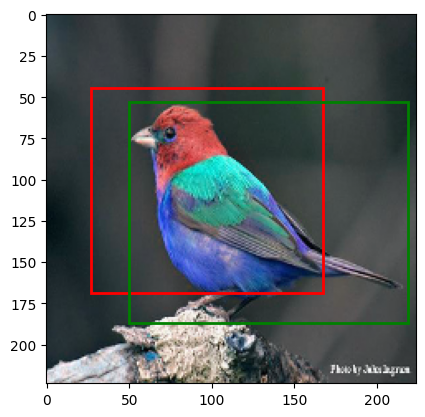

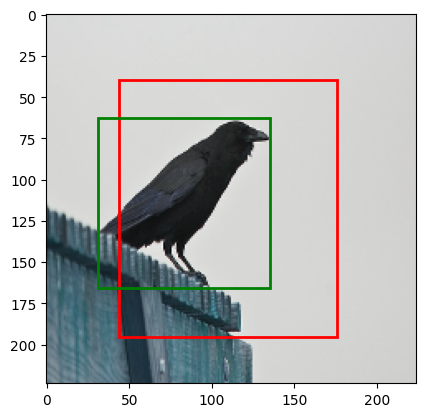

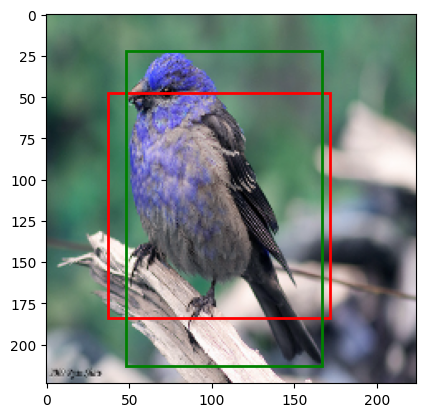

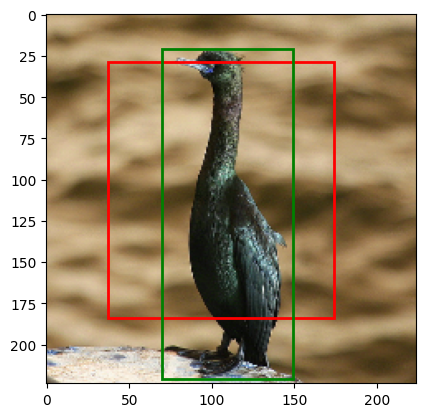

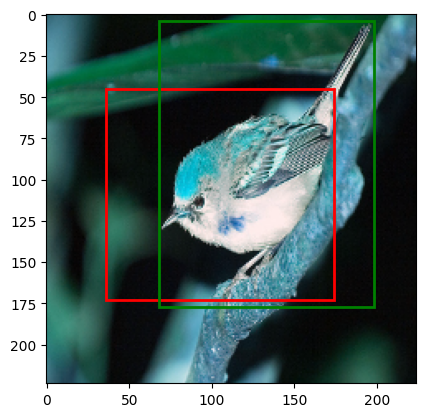

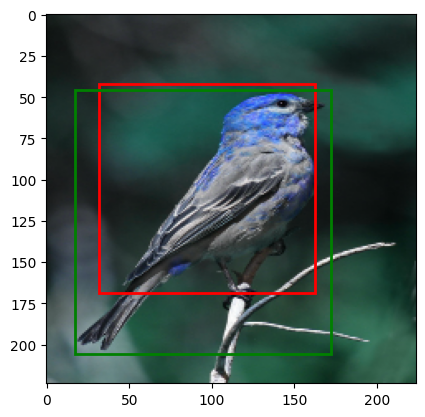

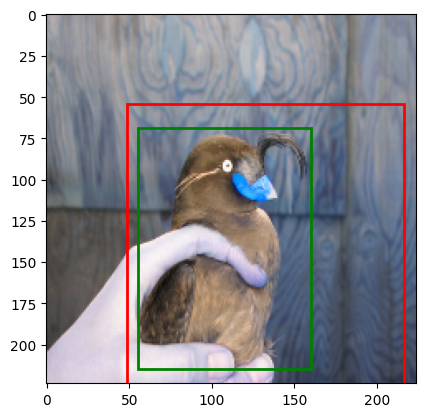

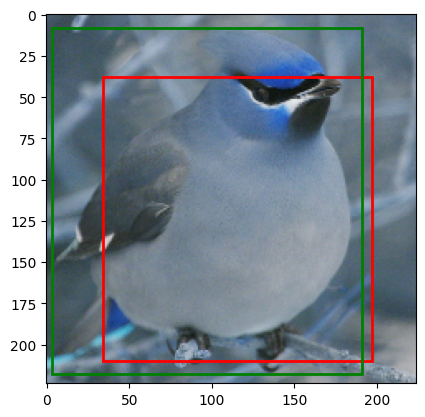

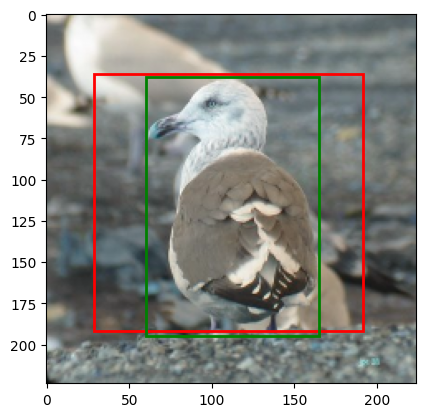

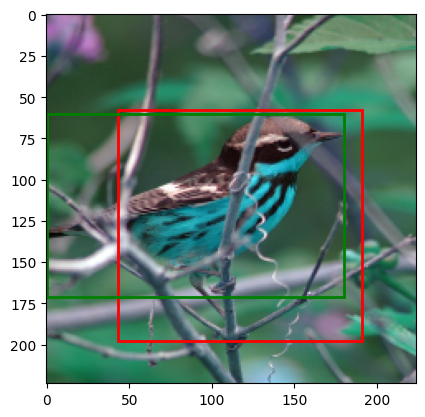

In [37]:
num_images_to_visualize = 10
count = 0

for batch_images, batch_labels in valid_dataset:
    predictions = ssd_model.predict(batch_images)

    for i in range(len(batch_images)):
        # batch_labels[i] 應該包含真實標籤的邊界框
        # predictions[i] 應該包含預測的邊界框
        # 如果 batch_labels 或 predictions 不是 NumPy 陣列，您可能需要將它們轉換過來
        visualize_predictions(batch_images[i], predictions[i], batch_labels[i])
        count += 1

        if count >= num_images_to_visualize:
            break

    if count >= num_images_to_visualize:
        break
